# Sippycup semantic parsing

In [25]:
import sys
sys.path.append('3rdparty/sippycup')
from annotator import *
from parsing import *

In [26]:
import spacy
nlp = spacy.load("en_core_web_md")

In [27]:
def add_rule(grammar, rule):
    if contains_optionals(rule):
        add_rule_containing_optional(grammar, rule)
    elif is_lexical(rule):
        grammar.lexical_rules[rule.rhs].append(rule)
    elif is_unary(rule):
        grammar.unary_rules[rule.rhs].append(rule)
    elif is_binary(rule):
        grammar.binary_rules[rule.rhs].append(rule)
    elif all([is_cat(rhsi) for rhsi in rule.rhs]):
        add_n_ary_rule(grammar, rule)
    else:
        make_cat(grammar, rule)
        # raise Exception('RHS mixes terminals and non-terminals: %s' % rule

def add_rule_containing_optional(grammar, rule):
    # Find index of the first optional element on the RHS.
    first = next((idx for idx, elt in enumerate(rule.rhs) if is_optional(elt)), -1)
    assert first >= 0
    assert len(rule.rhs) > 1, 'Entire RHS is optional: %s' % rule
    prefix = rule.rhs[:first]
    suffix = rule.rhs[(first + 1):]
    # First variant: the first optional element gets deoptionalized.
    deoptionalized = (rule.rhs[first][1:],)
    add_rule(grammar, Rule(rule.lhs, prefix + deoptionalized + suffix, rule.sem))
    # Second variant: the first optional element gets removed.
    # If the semantics is a value, just keep it as is.
    sem = rule.sem
    # But if it's a function, we need to supply a dummy argument for the removed element.
    if isinstance(rule.sem, FunctionType):
        sem = lambda sems: rule.sem(sems[:first] + [None] + sems[first:])
    add_rule(grammar, Rule(rule.lhs, prefix + suffix, sem))

def make_cat(grammar, rule):
    """
    Convert a terminal in the RHS into a non-terminal.
    
    Conversion works by creating a nonterminal from each terminal if
    it does not exist already in the grammar, otherwise it just replaces it.
    """
    
    new_rhs = []
    for rhsi in rule.rhs:
        if is_cat(rhsi):
            cat_name = rhsi
        else:
            cat_name = "$" + rhsi + "__nonterminal"
            if cat_name not in grammar.categories:
                grammar.categories.add(cat_name)
                # print(f"Adding rule: {cat_name} := {str(rhsi)}")
                add_rule(grammar, Rule(cat_name, rhsi))
        new_rhs.append(cat_name)
        # print(f"Adding rule: {rule.lhs} := {str(new_rhs)}")
    add_rule(grammar, Rule(rule.lhs, tuple(new_rhs), rule.sem))



In [28]:
def parse_input(grammar, input):
    """Returns a list of all parses for input using grammar."""
    tokens_spacy = nlp(input) # New
    tokens = [token.text for token in tokens_spacy]
    chart = defaultdict(list)
    for j in range(1, len(tokens) + 1):
        for i in range(j - 1, -1, -1):
            apply_annotators(grammar, chart, tokens, i, j)
            apply_lexical_rules(grammar, chart, tokens, i, j)
            apply_binary_rules(grammar, chart, i, j)
            apply_unary_rules(grammar, chart, i, j)
    parses = chart[(0, len(tokens))]
    if hasattr(grammar, 'start_symbol') and grammar.start_symbol:
        parses = [parse for parse in parses if parse.rule.lhs == grammar.start_symbol]
    return parses

class Grammar:
    def __init__(self, rules=[], annotators=[], start_symbol='$ROOT'):
        self.categories = set()
        self.lexical_rules = defaultdict(list)
        self.unary_rules = defaultdict(list)
        self.binary_rules = defaultdict(list)
        self.annotators = annotators
        self.start_symbol = start_symbol
        for rule in rules:
            add_rule(self, rule)
        print('Created grammar with %d rules.' % len(rules))

    def parse_input(self, input):
        """Returns a list of parses for the given input."""
        return parse_input(self, input)

In [29]:
NumberAnnotator().annotate(['16'])

[('$Number', 16)]

In [30]:
TokenAnnotator().annotate(['foo'])

[('$Token', 'foo')]

In [31]:
class StopWordAnnotator(Annotator):
    """Let spacy detect stop words for us"""
    def annotate(self, tokens):
        if len(tokens) == 1:
            if nlp(tokens[0])[0].is_stop:
                return [('$StopWord', tokens[0])]
        return []

class ShowVerbAnnotator(Annotator):
    def __init__(self, threshold = 0.7):
        self.show_verbs = [("define", ""), ("tell", "me"), ("show", "me")]
        self.spacy_show_toks = nlp(" ".join([verb for verb, _ in self.show_verbs]))
        self.threshold = 0.7

    def annotate(self, tokens):
        if len(tokens) <= 2:
            spacy_tokens = nlp(" ".join(tokens))
            spacy_token = spacy_tokens[0]
            if spacy_token.pos_ != 'VERB':
                return []
            
            # If the verb matches in meaning and, in case it requires a
            # follow-up word, that this matches as well, then it's a match.
            for idx, (verb, acc) in enumerate(self.show_verbs):
                spacy_verb = self.spacy_show_toks[idx]
                if spacy_token.similarity(spacy_verb) >= self.threshold:
                    if verb == tokens[0] and acc != "" and (len(tokens) == 1 or tokens[1] != acc):
                        return []
                    return [('$ShowVerb', tokens)]
        return []

    
class TokenAnnotatorBuilder(Annotator):
    def __init__(self, category_name, excluded):
        Annotator.__init__(self)
        self.category_name = category_name
        self.excluded = excluded
    
    def annotate(self, tokens):
        if len(tokens) == 1:
            token = tokens[0]
            if token not in self.excluded:
                return [(self.category_name, token)]
        return []

In [32]:
ShowVerbAnnotator().annotate(['say'])

[('$ShowVerb', ['say'])]

In [33]:
ShowVerbAnnotator().annotate(['define'])

[('$ShowVerb', ['define'])]

In [34]:
ShowVerbAnnotator().annotate(['tell', 'me'])

[('$ShowVerb', ['tell', 'me'])]

In [35]:
TokenAnnotatorBuilder('TokenWithoutQuotes', ['"', '"']).annotate(['Jeff'])

[('TokenWithoutQuotes', 'Jeff')]

In [36]:
MAX_CELL_CAPACITY = 10000

# Grammar definition

We will model the queries after a few intents:

- Definition: asking for a definition of a noun phrase
- Comparison: compare two noun phrases
- Filtering/Details on a given sense: ask for further details on a previously mentioned sense
- Usage of form
- General grammar knowledge

In [37]:
from functools import reduce

def sems_0(sems):
    return sems[0]

def sems_1(sems):
    return sems[1]

def sems_2(sems):
    return sems[2]

def merge_dicts(d1, d2):
    if not d2:
        return d1
    if not d1:
        return {}
    return {**d1, **d2}

def strip_none(sems):
    return [sem for sem in sems if sem]

def merge_dicts_singleparam(sems):
    if all([sem is None for sem in sems]):
        return {}
    return reduce(merge_dicts, strip_none(sems))

def to_np(sems):
    return {'np': strip_none(sems)[0]}

def concatenate(sems):
    return " ".join(strip_none(sems))


rules_definition = [
    Rule('$ROOT', '$DefinitionQuery', sems_0),
    Rule('$DefinitionQuery', '$DefinitionQueryElements',
         lambda sems: merge_dicts({'intent': 'define'}, sems[0])),
    Rule('$DefinitionQueryElements', '$DefinitionQuestion $NounPhrase',
         merge_dicts_singleparam),
    
    # Special case: "what does X mean?"
    Rule('$DefinitionQueryElements', 'what does $NounPhrase mean', sems_2),
    
    Rule('$DefinitionQuestion', '$ShowVerb ?me ?$Determiner'),
    Rule('$DefinitionQuestion', '$ShowVerb ?me $WhoDefinition'),
    Rule('$DefinitionQuestion', '$ShowVerb ?me $WhatDefinition'),
    Rule('$DefinitionQuestion', '$WhatDefinition'),
    Rule('$DefinitionQuestion', '$WhoDefinition', {'isPerson': True}),
    Rule('$WhoDefinition', 'who $Be'),
    Rule('$WhatDefinition', 'what $Be ?$Determiner ?$DefinitionFor'),
    Rule('$WhatDefinition', 'how do you $ShowVerb'),
    Rule('$DefinitionFor', '$WordSense $StopWord'),
    Rule('$NounPhrase', "$Tokens", to_np),
    Rule('$NounPhrase', "' $Tokens '", to_np),
    Rule('$NounPhrase', '" $Tokens "', to_np),
    Rule('$Tokens', '$UnquotedToken ?$Tokens', concatenate)
]

rules_determiner = [
    Rule('$Determiner', 'a'),
    Rule('$Determiner', 'an'),
    Rule('$Determiner', 'the'),
    Rule('$Determiner', 'about the'),
    Rule('$Determiner', 'its'),
    Rule('$Determiner', "any"),
    Rule('$Determiner', "some"),
]

rules_be = [
    Rule("$Be", "is"),
    Rule("$Be", "are"),
    Rule("$Be", "'s"),
    Rule("$Be", "were"),
    Rule("$Be", "was"),
    Rule("$Be", "be"),
    Rule("$Be", "being"),
]

rules_wordsenses = [
    Rule("$WordSense", "one"),
    Rule("$WordSense", "sense"),
    Rule("$WordSense", "meaning"),
    Rule("$WordSense", "definition"),
    Rule("$WordSense", "definitions"),
    Rule("$WordSense", "possibility"),
    Rule("$WordSense", "possibilities"),
    Rule("$WordSense", "case"),
    Rule("$WordSense", "field"),
]

In [38]:
annotators = [StopWordAnnotator(), ShowVerbAnnotator(), TokenAnnotatorBuilder("$UnquotedToken", ["'", '"', "?"])]
rules = rules_definition + rules_determiner + rules_be + rules_wordsenses
grammar = Grammar(rules=rules, annotators=annotators)
parses = grammar.parse_input('define pi')
parse = parses[0]

Created grammar with 40 rules.


In [39]:
parse.semantics

{'intent': 'define', 'np': 'pi'}

In [40]:
parses = grammar.parse_input('define "pi"')

In [41]:
grammar.parse_input('who is apollo')[0].semantics

{'intent': 'define', 'isPerson': True, 'np': 'apollo'}

In [42]:
parses[0].semantics

{'intent': 'define', 'np': 'pi'}

In [43]:
def pretty_print(parse, depth=0):
    if not isinstance(parse, str):
        if depth > 0:
            for _ in range(1):
                print("|")
        print("-" * depth * 2, parse.rule.lhs, parse.rule.rhs)
        for child in parse.children:
            pretty_print(child, depth+1)

pretty_print(parses[0])

 $ROOT ('$DefinitionQuery',)
|
-- $DefinitionQuery ('$DefinitionQueryElements',)
|
---- $DefinitionQueryElements ('$DefinitionQuestion', '$NounPhrase')
|
------ $DefinitionQuestion ('$ShowVerb',)
|
-------- $ShowVerb ('define',)
|
------ $NounPhrase ('$"__nonterminal', '$NounPhrase_$"__nonterminal')
|
-------- $"__nonterminal ('"',)
|
-------- $NounPhrase_$"__nonterminal ('$Tokens', '$"__nonterminal')
|
---------- $Tokens ('$UnquotedToken',)
|
------------ $UnquotedToken ('pi',)
|
---------- $"__nonterminal ('"',)


In [44]:
def print_parse(grammar, utterances):
    for utterance in utterances:
        print("=" * 20)
        print("For the utterance " + utterance + ":")
        for parse in grammar.parse_input(utterance):
            print(parse.semantics)

In [45]:
# parses = grammar.parse_input("define 'pi'")
define_utterances = ["define pie", "tell me about the life", "what is an 'apple'",
                         "what is the definition of botanics", "what does mechanophilia mean",
                         "what is apollo", "who is apollo", "what are ants",
                         "what are definitions for love"]
print_parse(grammar, define_utterances)

For the utterance define pie:
{'intent': 'define', 'np': 'pie'}
For the utterance tell me about the life:
{'intent': 'define', 'np': 'about the life'}
{'intent': 'define', 'np': 'life'}
For the utterance what is an 'apple':
{'intent': 'define', 'np': 'apple'}
For the utterance what is the definition of botanics:
{'intent': 'define', 'np': 'the definition of botanics'}
{'intent': 'define', 'np': 'definition of botanics'}
{'intent': 'define', 'np': 'botanics'}
For the utterance what does mechanophilia mean:
{'intent': 'define', 'np': 'mechanophilia'}
For the utterance what is apollo:
{'intent': 'define', 'np': 'apollo'}
For the utterance who is apollo:
{'intent': 'define', 'isPerson': True, 'np': 'apollo'}
For the utterance what are ants:
{'intent': 'define', 'np': 'ants'}
For the utterance what are definitions for love:
{'intent': 'define', 'np': 'definitions for love'}
{'intent': 'define', 'np': 'love'}


### Filter intents

- "show me the third sense"
- "tell me more about the mathematical meaning"
- "show me some examples"

In [46]:
from text_to_num import alpha2digit

def remove_suffix(word: str, suffix: str):
    """Remove a suffix from a string. """
    if word.endswith(suffix):
        return word[:-len(suffix)]
    return word

def convert_ordinal(word: str):
    """Convert a number to ordinal"""
    basic_forms = {"first": "one",
                   "second": "two",
                   "third": "three",
                   "fifth": "five",
                   "twelfth": "twelve"}
    
    for k, v in basic_forms.items():
        word = word.replace(k, v)
    
    word = word.replace("ieth", "y")
    
    for pattern in ["st", "nd", "rd", "th", "°"]:
        word = remove_suffix(word, pattern)
    
    converted = alpha2digit(word, "en")
    try:
        return int(converted)
    except:
        return None

class OrdinalNumberAnnotator(Annotator):
    def annotate(self, tokens):
        if len(tokens) > 1:
            return []
        value = convert_ordinal(tokens[0])
        if value:
            return [('$OrdinalNumber', value)]
        return []

In [47]:
OrdinalNumberAnnotator().annotate(['fortieth'])

[('$OrdinalNumber', 40)]

In [48]:
%load_ext autoreload
%autoreload 2

from tools.providers import FusekiProvider

fuseki_provider = FusekiProvider()
poses = fuseki_provider.dump_pos_categories()['posEntity'].str[4:]
poses.to_list()

['adverb',
 'verb',
 'noun',
 'propername',
 'determiner',
 'preposition',
 'adjective',
 'interjection',
 'conjunction',
 'particle',
 'pronoun',
 'adposition',
 'affix',
 'article',
 'postposition',
 'letter',
 'prefix',
 'proverb',
 'punctuation',
 'symbol',
 'suffix']

In [49]:
categories_set = set(fuseki_provider.fetch_all_grammatical_categories().to_list())

"plural" in categories_set

True

In [50]:
class POSAnnotator(Annotator):
    pos_categories = fuseki_provider.dump_pos_categories()['posEntity'].str[4:].to_list()
    
    def annotate(self, tokens):
        if len(tokens) != 1:
            return []
        # get the singular for the POS
        candidate = nlp(tokens[0])[0].lemma_
        if candidate in POSAnnotator.pos_categories:
            return [('$POS', candidate)]
        return []


class GrammaticalFeatureAnnotator:
    def annotate(self, tokens):
        candidate = " ".join(tokens)
        if candidate in categories_set:
            return [("$GrammaticalFeature", candidate)]
        return []

In [51]:
def foo(type_):
    def f(sems):
        return merge_dicts({'filtertype': type_, 'value': sems[4]}, sems[1])
    return f

def as_constraint(sem):
    return {'constraints': sem}
    

rules_filter = [
    Rule('$ROOT', '$FilterQuery', lambda sems: merge_dicts({'intent': 'filter'}, sems[0])),
    # Tell me about...
    Rule('$FilterQuery', '?$ShowVerb $FilterQueryElements', sems_1),
    Rule('$FilterQuery', '?$ShowVerb ?$StopWord $FilterQueryElements', sems_2),
    # What about...
    Rule('$FilterQuery', 'what about $FilterQueryElements', sems_2),
    # What are the...
    Rule('$FilterQuery', 'what $Be ?$Determiner $FilterQueryElements', lambda sems: sems[3]),
    # "which examples are available?"
    Rule('$FilterQuery', 'what $FilterQueryElements $be $More', sems_1),
    Rule('$FilterQuery', 'which $FilterQueryElements $be $More', sems_1),
    Rule('$FilterQuery', '$FilterQueryElements', sems_0),
    
    
    # ordinal case
    Rule('$FilterQueryElements', "?$More the $OrdinalNumber ?$WordSense ?$Only",
         lambda sems: {'filtertype': 'number', 'value': strip_none(sems)[0]}),
         
    # "more about the mathematical case"
    Rule('$FilterQueryElements', "?$More the $UnquotedToken $WordSense ?$Only",
         lambda sems: {'filtertype': 'semantic', "value": strip_none(sems)[0]}),
    
    # some examples
    Rule('$FilterQueryElements', '?$More $Extra', sems_1),
    # some examples for the second case
    Rule('$FilterQueryElements', '?$More $Extra $StopWord ?$Determiner $OrdinalNumber $WordSense ?$Only',
         #lambda sems: merge_dicts({'type': 'number', 'value': sems[4]}, sems[1])),
         foo('number')),
         
    # some examples for the botanical case
    Rule('$FilterQueryElements', '?$More $Extra $StopWord ?$Determiner $UnquotedToken $WordSense ?$Only',
         # lambda sems: merge_dicts({'type': 'sense_meaning', 'value': sems[4]}, sems[1])),
         foo('semantic')),

    # some examples as a verb
    Rule('$FilterQueryElements', '?$More $Extra ?$Filler $StopWord ?$Determiner $POS',
         # lambda sems: merge_dicts({'type': 'sense_meaning', 'value': sems[4]}, sems[1])),
         lambda sems: merge_dicts({'filtertype': 'grammatical', 'requiredPos': sems[5]}, sems[1])),
    
    # Show me the plural form
    Rule("$FilterQueryElements", "$Determiner $GrammaticalFeature ?form",
         lambda sems: {'filtertype': 'grammatical', 'grammaticalFeature': sems[1]}),
    
    # Ask for examples, categories or usages
    Rule('$Extra', 'examples', {'variant': "example"}),
    Rule('$Extra', 'categories', {'variant': "categories"}),
    Rule('$Extra', 'usages', {'variant': "usages"}),
    Rule('$Extra', 'senses', {'variant': "senses"}),
    Rule('$Extra', 'parts of speech', {'variant': "pos"}),
    Rule('$Extra', 'conjugate', {'variant': "forms"}),
    Rule('$Extra', 'conjugation', {'variant': "forms"}),
    Rule('$Extra', 'forms', {'variant': "forms"}),
    
    # Category question where category precedes the rest
    Rule('$FilterQuery', "$FilterCategoryQuery",
         lambda sems: merge_dicts({'filtertype': 'semantic'}, sems[0])),
    # in the field of computer science, what does x mean?
    Rule('$FilterCategoryQuery', "$Category $WhatFilter", sems_0),
    Rule('$FilterCategoryQuery', "$WhatFilter $Category", sems_1),
    Rule('$FilterCategoryQuery', "$Category $?More $Extra", merge_dicts_singleparam),
    
    
    Rule('$More', "more"),
    Rule('$More', "more about"),
    Rule('$More', "some"),
    Rule('$More', "some some"),
    Rule('$More', "any"),
    Rule('$More', 'possible'),
    Rule('$More', 'available'),

    
    Rule("$Only", "only"),
    Rule("$Only", "alone"),
    
    # for "X", as in "show me more examples for 'snow"
    Rule("$Filler", "$StopWord $NounPhrase"),
    
    Rule("$Category", "in $Determiner $WordSense $StopWord $NounPhrase ?,", lambda sems: {'category': sems[4]['np']}),
    Rule("$WhatFilter", "what does $NounPhrase mean"),
    Rule("$WhatFilter", "what $Be $Determiner $WordSense"),
]


In [52]:
annotators = [StopWordAnnotator(), ShowVerbAnnotator(),
                TokenAnnotatorBuilder("$UnquotedToken", ["'", '"', "?", ","]), # commas must split noun phrases
                OrdinalNumberAnnotator(), POSAnnotator(),
                GrammaticalFeatureAnnotator()]

rules_2 = rules_definition + rules_determiner + rules_filter + rules_be + rules_wordsenses

grammar_2 = Grammar(rules=rules_2, annotators=annotators)

Created grammar with 80 rules.


In [53]:
filter_utterances = ["tell me the first one", "tell me the mathematical one only",
                         "tell me more examples", "what about more examples for the first one",
                         "show me more examples for the chemistry one", "show me more examples as a noun",
                         "show me more examples of home as a verb", "more examples of home as a verb",
                         "in the field of biology, what is the definition",
                         "what does it mean in the field of computer science",
                         "tell me the singular form",
                         "more examples",
                         "what are the available parts of speech"]

print_parse(grammar_2, filter_utterances)

For the utterance tell me the first one:
{'intent': 'filter', 'filtertype': 'semantic', 'value': 'first'}
{'intent': 'filter', 'filtertype': 'semantic', 'value': 'first'}
{'intent': 'filter', 'filtertype': 'number', 'value': 1}
{'intent': 'filter', 'filtertype': 'number', 'value': 1}
{'intent': 'define', 'np': 'the first one'}
{'intent': 'define', 'np': 'first one'}
For the utterance tell me the mathematical one only:
{'intent': 'filter', 'filtertype': 'semantic', 'value': 'mathematical'}
{'intent': 'filter', 'filtertype': 'semantic', 'value': 'mathematical'}
{'intent': 'define', 'np': 'the mathematical one only'}
{'intent': 'define', 'np': 'mathematical one only'}
For the utterance tell me more examples:
{'intent': 'filter', 'variant': 'example'}
{'intent': 'filter', 'variant': 'example'}
{'intent': 'filter', 'variant': 'example'}
{'intent': 'define', 'np': 'more examples'}
For the utterance what about more examples for the first one:
{'intent': 'filter', 'filtertype': 'semantic', 'va

### Related intent

- What are possible synonyms?
- What are its opposites?
- What are related words? (generic)

In [54]:
rules_derived = [
    Rule('$ROOT', '$RelatedQuery', lambda sems: merge_dicts({'intent': 'related'}, sems[0])),
    
    Rule('$RelatedQuery', '?$ShowVerb $RelatedQueryElements', sems_1),
    # What are related senses?
    Rule('$RelatedQuery', 'what $Be $RelatedQueryElements', sems_2),
    Rule('$RelatedQuery', 'which $Be $RelatedQueryElements', sems_2),
    # What senses are related
    Rule('$RelatedQuery', 'what $Word $Be $RelatedQueryElements', lambda sems: sems[3]),
    Rule('$RelatedQuery', '$RelatedQueryElements', sems_0),
    Rule('$RelatedQueryElements', '?$Determiner $Derived ?$Word', sems_1),
    Rule('$RelatedQueryElements', '?$More $Derived ?$Word', sems_1),
    Rule('$RelatedQueryElements', '?$Determiner $Quality $Derived', lambda sems: merge_dicts(sems[1], sems[2])),
    Rule('$RelatedQueryElements', '?$More $Quality $Derived', lambda sems: merge_dicts(sems[1], sems[2])),
    
    
     # some examples of the derived words
    Rule('$RelatedQueryElements', '?$More $Extra $StopWord ?$Determiner $Derived ?$Word',
         lambda sems: merge_dicts(sems[1], sems[4])),
         
    Rule('$Derived', 'derived', {'filtertype': 'derived'}),
    Rule('$Derived', 'synonym', {'filtertype': 'synonym'}),
    Rule('$Derived', 'synonyms', {'filtertype': 'synonym'}),
    Rule('$Derived', 'antonym', {'filtertype': 'antonym'}),
    Rule('$Derived', 'opposites', {'filtertype': 'antonym'}),
    Rule('$Derived', 'antonyms', {'filtertype': 'antonym'}),
    Rule('$Derived', 'related', {'filtertype': 'related'}),
    
    Rule('$Quality', '$UnquotedToken', lambda sems: {'category': sems[0]}),
]

rules_words = [
    Rule('$Word', 'word'),
    Rule('$Word', 'words'),
    Rule('$Word', 'lexeme'),
    Rule('$Word', 'lexemes'),
    Rule('$Word', 'lemma'),
    Rule('$Word', 'lemmas'),
]


In [55]:
rules_3 = rules_be + rules_definition + rules_determiner + rules_filter + rules_words + rules_wordsenses + rules_derived


grammar_3 = Grammar(rules=rules_3, annotators=annotators)

Created grammar with 105 rules.


In [56]:
related_utterances = ["what are derived words", "what are possible derived words",
                          "show me some antonyms", "show me some stylish synonyms",
                          "what are some opposites"]

print_parse(grammar_3, related_utterances)

For the utterance what are derived words:
{'intent': 'related', 'filtertype': 'derived'}
{'intent': 'related', 'filtertype': 'derived'}
{'intent': 'define', 'np': 'derived words'}
For the utterance what are possible derived words:
{'intent': 'related', 'filtertype': 'derived'}
{'intent': 'define', 'np': 'possible derived words'}
For the utterance show me some antonyms:
{'intent': 'related', 'filtertype': 'antonym'}
{'intent': 'related', 'filtertype': 'antonym'}
{'intent': 'related', 'category': 'some', 'filtertype': 'antonym'}
{'intent': 'related', 'category': 'some', 'filtertype': 'antonym'}
{'intent': 'define', 'np': 'some antonyms'}
{'intent': 'define', 'np': 'antonyms'}
For the utterance show me some stylish synonyms:
{'intent': 'related', 'category': 'stylish', 'filtertype': 'synonym'}
{'intent': 'related', 'category': 'stylish', 'filtertype': 'synonym'}
{'intent': 'define', 'np': 'some stylish synonyms'}
{'intent': 'define', 'np': 'stylish synonyms'}
For the utterance what are so

### Decide queries

- is it regular?
- is family a synonym for collection?
- can adverbs have a comparative form?
- can it be used as a noun
- do nouns have comparatives?

In [57]:
rules_decide = [
    Rule('$ROOT', '$DecideQuery',
         lambda sems: merge_dicts({'intent': 'decide'}, sems[0])),
    
    # is it a noun?
    Rule('$DecideQuery', '$Be $DecideQuerySubject ?$Determiner $DecideQueryObject',
        merge_dicts_singleparam),
    
    Rule('$DecideQuery', 'can $DecideQuerySubject $Be ?$Determiner $DecideQueryObject',
         merge_dicts_singleparam),
    
    # can reticence be used as a noun
    Rule('$DecideQuery', 'can $DecideQuerySubject ?$Be $UsedLike $DecideQueryObject',
         merge_dicts_singleparam),
    
    Rule('$DecideQuery', 'can $DecideQuerySubject $Have ?$Determiner $DecideQueryObject',
         merge_dicts_singleparam),
    
    Rule('$DecideQuery', '$Do $DecideQuerySubject $Have ?$Determiner $DecideQueryObject',
         merge_dicts_singleparam),
    
    
    # do adverbs have comparatives?
    Rule('$DecideQuery', '$Do $DecideQuerySubject $Have $DecideQueryObject',
         merge_dicts_singleparam),
    
    
    Rule('$DecideQuerySubject', "it"),
    Rule('$DecideQuerySubject', "$POS",
         lambda sems: {"filtertype": "grammatical", "requiredPos": sems[0]}),
    
    # "is family a noun?"
    Rule('$DecideQuerySubject', "$NounPhrase", sems_0),
    
    # is it a noun
    Rule('$DecideQueryObject', "$POS",
         lambda sems: {'filtertype': 'grammatical', 'requiredPos': sems[0]}),
    
    # is it a comparative
    Rule('$DecideQueryObject', "$GrammaticalFeature ?$FormStopword",
         lambda sems: {'filtertype': 'grammatical', 'grammaticalFeature': sems[0]}),
    
    # does it have opposites?
    Rule('$DecideQueryObject', "$Derived", sems_0),
    
    # does it have examples
    Rule('$DecideQueryObject', "$Extra", sems_0),
    
    # is it a synonym of love?
    Rule('$DecideQueryObject', "$Derived $StopWord $NounPhrase",
         lambda sems: merge_dicts(sems[0], {'relatedTerm': sems[2]['np']})),
    
    # examples, usages, senses...
    Rule('$DecideQueryObject', '$Extra', sems_0),
    
    Rule('$UsedLike', 'used as ?in ?$Determiner'),
    Rule('$UsedLike', 'used like ?in ?$Determiner'),
    Rule('$UsedLike', 'adopted ?in ?$Determiner'),
    
    Rule('$FormStopWord', "?morphological form"),
    Rule('$FormStopWord', "morphology"),
]

rules_have = [
    Rule("$Have", 'have'),
    Rule("$Have", 'has'),
    Rule("$Have", 'had'),
    Rule("$Have", 'having'),
    Rule("$Have", "' d")
]

rules_do = [
    Rule("$Do", 'do'),
    Rule("$Do", 'does'),
]

In [58]:
rules_4 = rules_be + rules_have + rules_do + rules_definition + \
            rules_determiner + rules_filter + rules_words + rules_wordsenses + \
            rules_derived + rules_decide


grammar_4 = Grammar(rules=rules_4, annotators=annotators)

Created grammar with 133 rules.


In [59]:
decision_utterances = ["is it singular", "is family a synonym of collection",
                           "can adverbs have tense", "can it be used as a noun",
                            "do nouns have comparative"]

print_parse(grammar_4, decision_utterances)

For the utterance is it singular:
{'intent': 'decide', 'filtertype': 'grammatical', 'grammaticalFeature': 'singular'}
{'intent': 'decide', 'np': 'it', 'filtertype': 'grammatical', 'grammaticalFeature': 'singular'}
For the utterance is family a synonym of collection:
{'intent': 'decide', 'np': 'family', 'filtertype': 'synonym', 'relatedTerm': 'collection'}
{'intent': 'decide', 'np': 'family a', 'filtertype': 'synonym', 'relatedTerm': 'collection'}
For the utterance can adverbs have tense:
{'intent': 'decide', 'filtertype': 'grammatical', 'requiredPos': 'adverb', 'grammaticalFeature': 'tense'}
{'intent': 'decide', 'np': 'adverbs', 'filtertype': 'grammatical', 'grammaticalFeature': 'tense'}
For the utterance can it be used as a noun:
{'intent': 'decide', 'filtertype': 'grammatical', 'requiredPos': 'noun'}
{'intent': 'decide', 'np': 'it', 'filtertype': 'grammatical', 'requiredPos': 'noun'}
{'intent': 'decide', 'np': 'it be', 'filtertype': 'grammatical', 'requiredPos': 'noun'}
For the utter

## Interlude: Question Answering demo

By now we'll ignore that a parsed sentence may (and usually does) bring about multiple semantics.

Instead, we'll hardcode a "simple" priority choice: take the semantics with the greatest number of keys. It should work in a number of situations.

In case the choices are only definitions, pick the one with the shortest np.

In case I have to choose between two filters, always prefer the number type.

In [60]:
from tools.providers import WiktionaryProvider
from tools.answering import QuestionAnsweringContext, DefinitionIntent, FilterIntent
from IPython.core.display import display, HTML

provider = WiktionaryProvider()

def priority_calculator(parse):
    filtertype_priority = {'grammatical': 1, 'semantic': 2, 'number': 3,
                  'synonym': 4, 'antonym': 4, 'derived': 4, 'related': 4}
    
    # the more keys, the better
    score = len(parse.keys()) * 10 + (filtertype_priority[parse['filtertype']] if 'filtertype' in parse else 0)
    
    # ... except for np
    score -=  12 * len(parse['np'].split(" ")) if 'np' in parse else 0
    return score
    
def pick_best_semantics(parses):
    """
    Return the most likely matching parse.
    
    This is a simple stub. Does not do any ML here, despite it could
    (and should), so use with care.
    """
    if parses == []:
        return {}
    semantics = [parse.semantics for parse in parses]
    
    if all(parse["intent"] == "define" for parse in semantics):
        picked_parser = min(semantics, key=lambda parse: len(parse["np"]))
    
    else:
        picked_parser = max(semantics, key=priority_calculator)
        
    return picked_parser

context = QuestionAnsweringContext()

INFO:root:Created grammar with 132 rules.
INFO:root:Load pretrained SentenceTransformer: bert-base-nli-mean-tokens
INFO:root:Did not find a '/' or '\' in the name. Assume to download model from server.
INFO:root:Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip
INFO:transformers.configuration_utils:loading configuration file /root/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip/0_BERT/config.json
INFO:transformers.configuration_utils:Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,


In [61]:
pick_best_semantics(grammar_4.parse_input("show me synonyms"))

{'intent': 'related', 'filtertype': 'synonym'}

In [62]:
pick_best_semantics(grammar_4.parse_input("show me antonyms"))

{'intent': 'related', 'filtertype': 'antonym'}

In [63]:
pick_best_semantics(grammar_4.parse_input("can it be used as an adjective"))

{'intent': 'decide', 'filtertype': 'grammatical', 'requiredPos': 'adjective'}

In [64]:
pick_best_semantics(grammar_2.parse_input('what about more examples for the first one'))

{'intent': 'filter', 'filtertype': 'number', 'value': 1, 'variant': 'example'}

In [65]:
pick_best_semantics(grammar_4.parse_input('show me some examples'))

{'intent': 'filter', 'variant': 'example'}

In [66]:
pick_best_semantics(grammar_4.parse_input('more examples for the botanics one'))

{'intent': 'filter',
 'filtertype': 'semantic',
 'value': 'botanics',
 'variant': 'example'}

In [67]:
pick_best_semantics(grammar_4.parse_input('more examples for the first one'))

{'intent': 'filter', 'filtertype': 'number', 'value': 1, 'variant': 'example'}

In [68]:
pick_best_semantics(grammar_4.parse_input('show me more examples for the first one'))

{'intent': 'filter', 'filtertype': 'number', 'value': 1, 'variant': 'example'}

In [69]:
pick_best_semantics(grammar_4.parse_input('define butterfly'))

{'intent': 'define', 'np': 'butterfly'}

## Sklearn evaluation

In [71]:
import json
import pandas as pd
from tools.dumps import wrap_open

with wrap_open("intents/sample.json") as fp:
    dataset = json.load(fp)

In [72]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
import copy

class SamplePreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X=None, Y=None):
        return self
    
    def transform(self, dataset):
        # simply return sessions as an array
        df = copy.deepcopy(dataset)
        sessions = df['sessions']
        for session in sessions:
            for turn in session['turns']:
                del turn['target']
            session['turns'] = [turn['utterance'] for turn in session['turns']]
        return sessions

sessions = SamplePreprocessor().fit_transform(dataset)
targets = [[turn['target'] for turn in session['turns']] for session in dataset['sessions']]
flattened_utterances = [[turn['utterance'] for turn in session['turns']] for session in dataset['sessions']]

In [73]:
class GrammarMatcher(BaseEstimator, TransformerMixin):
    """This class serves as an evaluation framework for an intent classifier"""
    def __init__(self, grammar: Grammar):
        self.grammar = grammar

    def fit(self, sessions=None, targets=None):
        """
        """
        return self
    
    def transform(self, sessions):
        """
        Convert the given sessions to intents.
        Sessions is expected to be the output of SampleProcessor.
        """
        targets = []
        for session in sessions:
            answers = []
            
            for utterance in session['turns']:
                utterance = utterance.strip().lower()
                utterance = utterance.replace("'", '"')

                for eos in [".", "?", "!"]:
                    utterance = remove_suffix(utterance, eos)

                answers.append(self.grammar.parse_input(utterance))
            targets.append(answers)
        return targets

In [74]:
import traceback

class GreedyMatcher(BaseEstimator, ClassifierMixin):
    def fit(self, sessions=None, target=None):
        return self

    def predict(self, sessions):
        target = []
        for session in sessions:
            turns = []
            for parses in session:
                try:
                    turns.append(pick_best_semantics(parses))
                except:
                    traceback.print_exception() 
                    turns.append({})
            target.append(turns)
        return target

In [75]:
greedy_matcher = Pipeline([('preprocessor', SamplePreprocessor()),
                                ('grammar_matcher', GrammarMatcher(grammar_4)),
                                ('picker', GreedyMatcher())])

greedy_matcher.fit(dataset, targets)
output = greedy_matcher.predict(dataset)

In [107]:
# A bunch of evaluation functions

from sklearn.metrics import precision_recall_fscore_support, classification_report
import numpy as np

def flatten(sequence):
    return sum(sequence, [])

def get_intent(sequence):
    return [intent['intent'] if len(intent) else 'unknown' for intent in flatten(sequence)]
    
# "perfect" scorers, because they check whether two values are equal
def perfect_accuracy(y_truth, y_pred, debug_x=None):
    # Concatenate lists-of-lists into flattened lists.
    # Not the most efficient, but I find it very neat
    y_truth = flatten(y_truth)
    y_pred = flatten(y_pred)
    utterances = sum(debug_x, []) if debug_x else None
    
    score = []
    for idx, (y_t, y_p) in enumerate(zip(y_truth, y_pred)):
        matched_items = len(set(y_t.items()) & set(y_p.items()))
        if len(y_t) == 0:
            score.append(1.0 if len(y_t.items()) == 0 else 0.0)
        else:
            score.append(matched_items / len(y_t))
        if debug_x and score[-1] < 1.0:
            print(utterances[idx], y_t, y_p)
            print("===")
        
    return np.average(score)


def intent_match_score(y_truth, y_pred):
    y_pred = get_intent(y_pred)
    y_truth = get_intent(y_truth)
    
    print(classification_report(y_truth, y_pred))

perfect_accuracy(targets, output, debug_x=flattened_utterances)

show me all meanings for 'desire' {'intent': 'define', 'np': 'desire', 'quantifier': 'all'} {}
===
show me all examples for stashes {'intent': 'define', 'np': 'stashes', 'all': True, 'variant': 'example'} {'intent': 'define', 'np': 'all examples for stashes'}
===
Compare with house {'intent': 'compare', 'comparisonTerm': 'house'} {}
===
What are stilish synonyms? {'intent': 'related', 'filtertype': 'synonym', 'category': 'stylish', 'variant': 'example'} {'intent': 'related', 'category': 'stilish', 'filtertype': 'synonym'}
===
What are derived words? {'intent': 'related', 'filtertype': 'derived', 'category': 'formal|researched|stylish', 'variant': 'example'} {'intent': 'related', 'filtertype': 'derived'}
===
In the field of biology, does it have special meanings? {'intent': 'filter', 'filtertype': 'semantic', 'category': 'biology'} {}
===
Tell me about run {'intent': 'define', 'np': 'run'} {'intent': 'define', 'np': 'about run'}
===
Show me usages of the past simple tense {'intent': 'fi

0.5437853107344633

In [108]:
intent_match_score(targets, output)

              precision    recall  f1-score   support

     compare       0.00      0.00      0.00         2
      decide       1.00      1.00      1.00         2
    decision       0.00      0.00      0.00         3
      define       0.70      0.84      0.76        19
      filter       0.93      0.45      0.60        29
     related       0.75      1.00      0.86         3
     unknown       0.06      1.00      0.12         1

    accuracy                           0.59        59
   macro avg       0.49      0.61      0.48        59
weighted avg       0.75      0.59      0.62        59



In [124]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 18}

matplotlib.rc('font', **font)

In [134]:
intent_match_score(targets, output)

              precision    recall  f1-score   support

     compare       0.00      0.00      0.00         2
      decide       1.00      1.00      1.00         2
    decision       0.00      0.00      0.00         3
      define       0.70      0.84      0.76        19
      filter       0.93      0.45      0.60        29
     related       0.75      1.00      0.86         3
     unknown       0.06      1.00      0.12         1

    accuracy                           0.59        59
   macro avg       0.49      0.61      0.48        59
weighted avg       0.75      0.59      0.62        59



In [135]:
y_pred = pd.Series(get_intent(targets))
y_truth = pd.Series(get_intent(output))

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8c627ebcd0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8c627ebcd0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

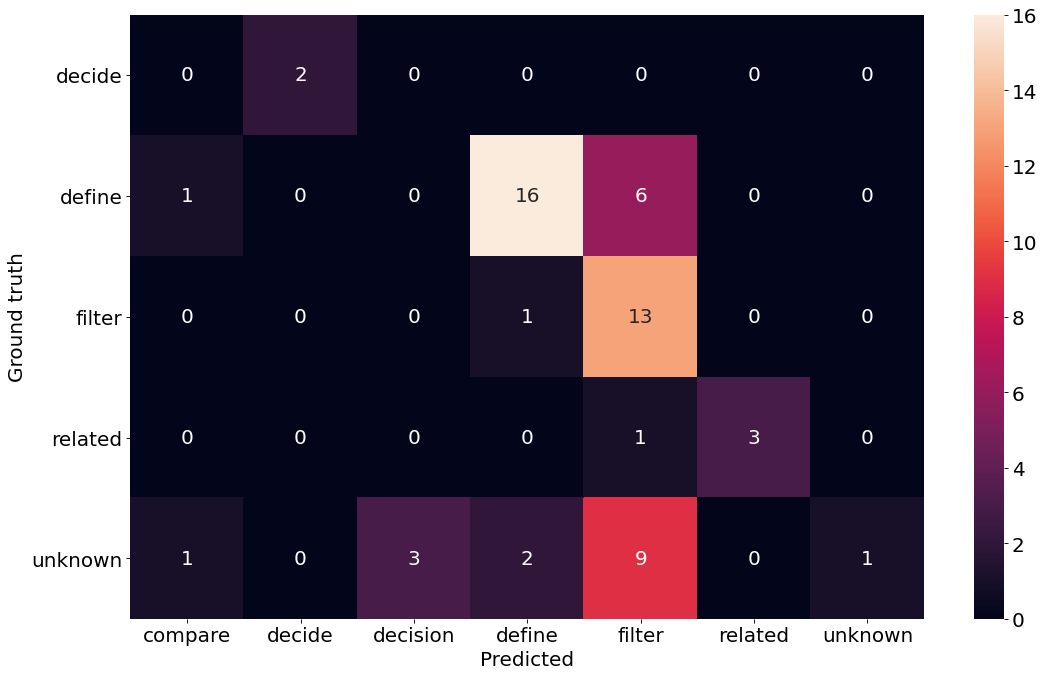

In [137]:
confusion_matrix = pd.crosstab(y_truth, y_pred, rownames=["Ground truth"], colnames=["Predicted"])
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(confusion_matrix, annot=True)


plt.yticks(rotation=0)